In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm


from warnings import filterwarnings
filterwarnings('ignore')

# Preprocessing

In [3]:
data = pd.read_csv("./gym_members_exercise_tracking.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [5]:
X = data[["Session_Duration (hours)", "Calories_Burned", "Fat_Percentage", "Water_Intake (liters)", "Workout_Frequency (days/week)"]]
y = data["Experience_Level"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
# Поділ даних на навчальну та тестову вибірки (70% на навчання, 30% на тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test  = le.transform(y_test)

In [8]:
num_classes = len(np.unique(y_train))
print("Класи:", np.unique(y_train))
print("Кількість класів:", num_classes)


Класи: [0 1 2]
Кількість класів: 3


In [9]:
def to_tensor(X, dtype=torch.float32):
    # якщо pandas DataFrame
    if hasattr(X, 'values'):
        return torch.tensor(X.values, dtype=dtype)
    else:  # якщо numpy.ndarray
        return torch.tensor(X, dtype=dtype)

def to_long_tensor(y):
    if hasattr(y, 'values'):
        return torch.tensor(y.values, dtype=torch.long)
    else:
        return torch.tensor(y, dtype=torch.long)

X_train_t = to_tensor(X_train)
X_test_t  = to_tensor(X_test)

y_train_t = to_long_tensor(y_train)
y_test_t  = to_long_tensor(y_test)

In [10]:
train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

# 1)Повнозв'язані нейронні мережі

In [11]:
class FFNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FFNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            # nn.ReLU(),
            # nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))

model = FFNN(input_dim, output_dim)
model

FFNN(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [12]:
# Функція втрат та оптимізатор

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Цикли навчання та тестування

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f"Batch {batch}: Loss = {loss.item():.4f}")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            predicted = pred.argmax(dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    avg_loss = test_loss / len(dataloader)
    accuracy = correct / total
    print(f"[TEST] Accuracy: {accuracy:.4f} | Avg Loss: {avg_loss:.4f}")

    return accuracy, avg_loss

In [14]:
# Навчання моделі

epochs = 20

for epoch in range(epochs):
    print(f"\n===== Epoch {epoch+1}/{epochs} =====")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)


===== Epoch 1/20 =====
Batch 0: Loss = 0.9379
[TEST] Accuracy: 0.5822 | Avg Loss: 0.8781

===== Epoch 2/20 =====
Batch 0: Loss = 0.7969
[TEST] Accuracy: 0.7055 | Avg Loss: 0.7750

===== Epoch 3/20 =====
Batch 0: Loss = 0.7161
[TEST] Accuracy: 0.7568 | Avg Loss: 0.6846

===== Epoch 4/20 =====
Batch 0: Loss = 0.6771
[TEST] Accuracy: 0.8048 | Avg Loss: 0.6041

===== Epoch 5/20 =====
Batch 0: Loss = 0.6459
[TEST] Accuracy: 0.8425 | Avg Loss: 0.5318

===== Epoch 6/20 =====
Batch 0: Loss = 0.5686
[TEST] Accuracy: 0.8630 | Avg Loss: 0.4700

===== Epoch 7/20 =====
Batch 0: Loss = 0.4915
[TEST] Accuracy: 0.8836 | Avg Loss: 0.4207

===== Epoch 8/20 =====
Batch 0: Loss = 0.3842
[TEST] Accuracy: 0.8836 | Avg Loss: 0.3818

===== Epoch 9/20 =====
Batch 0: Loss = 0.3303
[TEST] Accuracy: 0.8767 | Avg Loss: 0.3518

===== Epoch 10/20 =====
Batch 0: Loss = 0.2641
[TEST] Accuracy: 0.8836 | Avg Loss: 0.3287

===== Epoch 11/20 =====
Batch 0: Loss = 0.3338
[TEST] Accuracy: 0.8973 | Avg Loss: 0.3108

===== E

In [15]:
# Nочність на тесті

model.eval()
with torch.no_grad():
    preds = model(X_test_t).argmax(dim=1)

final_accuracy = accuracy_score(y_test, preds.numpy())
print("\nFinal Test Accuracy:", final_accuracy)


Final Test Accuracy: 0.8938356164383562


In [16]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
epochs = 20

results = {}  # сюди будемо збирати історію

for lr in learning_rates:
    print(f"\n===== Training with lr={lr} =====")
    model = FFNN(input_dim, output_dim)  # нова модель для кожного lr
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    acc_list, loss_list = [], []

    for epoch in range(epochs):
        train_loop(train_loader, model, loss_fn, optimizer)
        acc, avg_loss = test_loop(test_loader, model, loss_fn)
        acc_list.append(acc)
        loss_list.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} | Accuracy: {acc:.4f} | Avg Loss: {avg_loss:.4f}")

    results[lr] = {"accuracy": acc_list, "loss": loss_list}



===== Training with lr=0.0001 =====
Batch 0: Loss = 1.1721
[TEST] Accuracy: 0.4384 | Avg Loss: 1.1444
Epoch 1/20 | Accuracy: 0.4384 | Avg Loss: 1.1444
Batch 0: Loss = 1.0737
[TEST] Accuracy: 0.4623 | Avg Loss: 1.1258
Epoch 2/20 | Accuracy: 0.4623 | Avg Loss: 1.1258
Batch 0: Loss = 1.1615
[TEST] Accuracy: 0.4829 | Avg Loss: 1.1077
Epoch 3/20 | Accuracy: 0.4829 | Avg Loss: 1.1077
Batch 0: Loss = 1.2022
[TEST] Accuracy: 0.4829 | Avg Loss: 1.0903
Epoch 4/20 | Accuracy: 0.4829 | Avg Loss: 1.0903
Batch 0: Loss = 1.0649
[TEST] Accuracy: 0.5000 | Avg Loss: 1.0733
Epoch 5/20 | Accuracy: 0.5000 | Avg Loss: 1.0733
Batch 0: Loss = 1.0552
[TEST] Accuracy: 0.5171 | Avg Loss: 1.0565
Epoch 6/20 | Accuracy: 0.5171 | Avg Loss: 1.0565
Batch 0: Loss = 1.1696
[TEST] Accuracy: 0.5308 | Avg Loss: 1.0404
Epoch 7/20 | Accuracy: 0.5308 | Avg Loss: 1.0404
Batch 0: Loss = 1.0310
[TEST] Accuracy: 0.5411 | Avg Loss: 1.0242
Epoch 8/20 | Accuracy: 0.5411 | Avg Loss: 1.0242
Batch 0: Loss = 1.0603
[TEST] Accuracy: 0.5

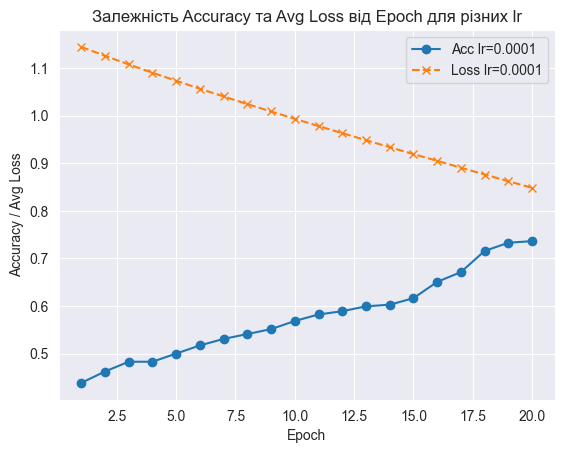

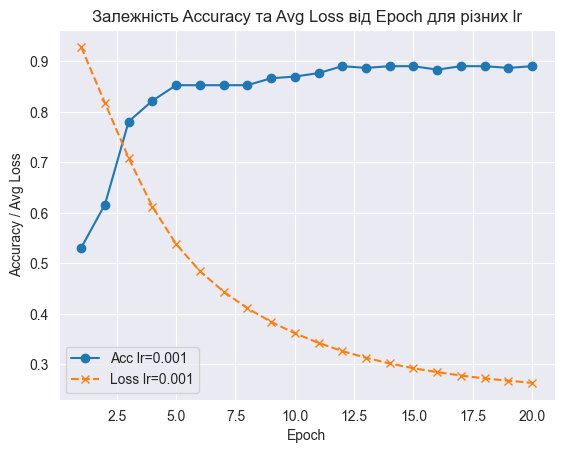

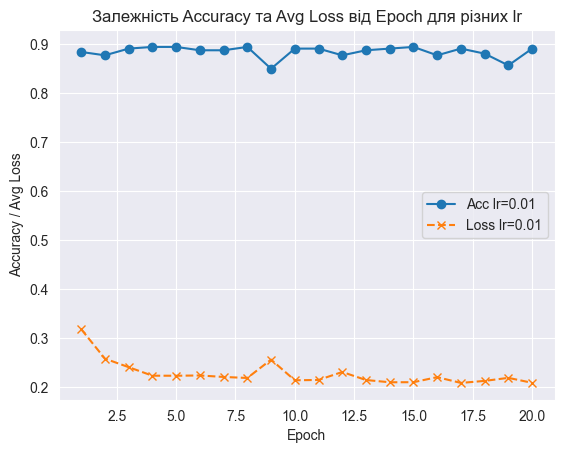

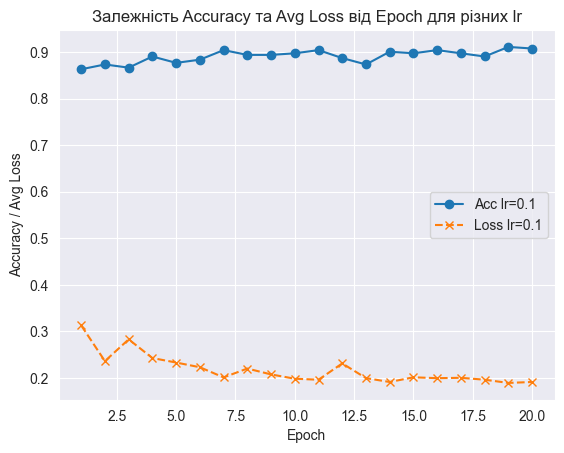

In [17]:
for lr in learning_rates:
    epochs_range = range(1, epochs+1)
    plt.plot(epochs_range, results[lr]["accuracy"], marker='o', label=f'Acc lr={lr}')
    plt.plot(epochs_range, results[lr]["loss"], marker='x', linestyle='--', label=f'Loss lr={lr}')

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy / Avg Loss")
    plt.title("Залежність Accuracy та Avg Loss від Epoch для різних lr")
    plt.legend()
    plt.grid(True)
    plt.show()
